## 安装

```bash
pip install -U jax
pip install -U flax
# pip install tensorflow tensorflow_datasets
pip install numpy optax dm-haiku numpyro numba tensorboardX 
pip install tqdm setproctitle dill
```


Docker中使用Jax，需要查看 [hardware_utils.py](https://github.com/jax-ml/jax/blob/main/jax/_src/hardware_utils.py) 是否包含了 
```py
_NVIDIA_GPU_DEVICES = [
    '/dev/nvidia0',
    '/dev/nvidiactl',  # Docker/Kubernetes
    '/dev/dxg',  # WSL2
]
```


本例中，[Optax](https://optax.readthedocs.io/en/latest/index.html)提供优化器，[dm-haiku](https://dm-haiku.readthedocs.io/en/latest/)提供NN（也可以使用[Flax](https://flax.readthedocs.io/en/latest/#basic-usage)），tqdm提供进度条



In [1]:
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import tensorflow as tf
import matplotlib.pyplot as plt
# %matplotlib inline


key = jax.random.PRNGKey(0)   
seedI, seedG = jax.random.split(key,2)

## Load Dataset
copy from "cGAN_TF.ipynb"

In [2]:
(train_imgs,train_labels),(test_imgs,test_labels) = tf.keras.datasets.mnist.load_data(path="L:/Datasets/mnist.npz")

BufferSize = train_imgs.shape[0]
BatchSize = 128

train_imgs = train_imgs/127.5-1
train_imgs = tf.expand_dims(train_imgs,-1)
# train_imgs = tf.cast(train_imgs, tf.float32)
# train_labels = tf.cast(train_labels, tf.float32)
trainloader = tf.data.Dataset.from_tensor_slices((train_imgs,train_labels)).shuffle(BufferSize).batch(BatchSize)

In [3]:
train_imgs.shape

TensorShape([60000, 28, 28, 1])

In [4]:
## View Img
def showBatchImg(images,labels,maxNum=5):
    fig, axes = plt.subplots(1, maxNum)
    for i in range(maxNum):
        axes[i].imshow(images[i].squeeze())    ## axes[i].imshow(images[i].numpy().squeeze())
        axes[i].set_title(labels[i].item())
        axes[i].axis('off')
    plt.show()

# showBatchImg(train_imgs, train_labels, 10)     ## showBatchImg(train_imgs, train_labels.cpu().numpy(), 10)

## Model -- Haiku

similiar as Classifier_Net in 'Basis_PyTorch.ipynb'

In [5]:
class Classifier_Haiku_Net(hk.Module):
    def __call__(self, x):
        x = hk.Conv2D(output_channels=32, kernel_shape=3, stride=1, padding='SAME')(x)   
        x = jax.nn.relu(x)
        x = hk.MaxPool(window_shape=(2,2), strides=(2,2), padding='VALID')(x)

        x = hk.Conv2D(output_channels=64, kernel_shape=3, stride=1, padding='SAME')(x)   
        x = jax.nn.relu(x)
        x = hk.MaxPool(window_shape=(2,2), strides=(2,2), padding='VALID')(x)

        x = hk.Flatten()(x)
        x = hk.Linear(128)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(10)(x)     ## out put logits here
        return x



def forwardH(x):
    netH = Classifier_Haiku_Net()
    return netH(x)


def loss_fn(params, seed, x, y):
    logits = modelH.apply(params, seed, x)             ## get model outputs
    onehot_y = jax.nn.one_hot(y, num_classes=10)
    loss = optax.softmax_cross_entropy(logits, onehot_y).mean()
    return loss


def cal_GradH(params, seed, x, y):
    loss, grad = jax.value_and_grad(loss_fn)(params, seed, x, y)
    return loss, grad


def updateH(optimizer, opt_state, params, grad):      ## return updated params
    updates, opt_state = optimizer.update(grad, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state




##   1. 实例化前向过程: transform func to Haiku block/model
modelH = hk.transform(forwardH)

##   2. init the model params:  params.keys() to see layer names
input_size = jnp.ones([BatchSize, 28, 28, 1])    ## train_imgs.shape
paramsH = modelH.init(seedI, input_size)         ## initial model params  

##   3. init the optimizer state (for adam)
optimizerH = optax.adam(learning_rate=1e-3)
opt_stateH = optimizerH.init(paramsH)


##   4. loss_fn
##   5. cal_GradH
##   6. updateH




## Training the model
for epoch in range(10):
    for x, y in trainloader.as_numpy_iterator():    ## otherwise x.numpy()
        x, y = jax.device_put(x), jax.device_put(y)
        _, grad = cal_GradH(paramsH, seedG, x, y)
        paramsH, opt_stateH = updateH(optimizerH, opt_stateH, paramsH, grad)


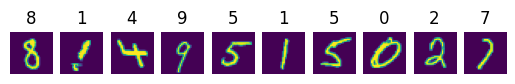

In [6]:
## Use the model
for x, y in trainloader.as_numpy_iterator(): 
    break

logits = modelH.apply(paramsH, seedG, x)
pred = jnp.argmax(logits, axis=1)
showBatchImg(x, pred, 10) 